# Hybrid recommendational System using LightFM + CatBoost

Task: predict whether users will like a social network post?

Input data
The dataset prepared by the VK team is available at https://cloud.mail.ru/public/oezf/KJSaChzoz .

It consists of several CSV files:

**topics.csv** — contains information about social network posts. Each entry is characterized by text and image attributes.

**users.csv** — contains information about users. Each user is characterized by date of birth, gender and city ID.

**train.csv** — contains information about user interaction social network posts. The type of interaction is equal to "L" if user liked the record, and "D" if he or she didn't like the record.

**test.csv** — contains the ids of the records and users for whom you have to predict the type of interaction.

In [14]:
# import dependent libraries
from tqdm.notebook import tqdm

import pandas as pd
from catboost import CatBoostClassifier
import os
from scipy.sparse import csr_matrix
import numpy as np
from IPython.display import display_html
import warnings

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
from skopt import forest_minimize

from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score

import numpy as np
from scipy.sparse import coo_matrix

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace(
        'table', 'table style="display:inline"'), raw=True)


# update the working directory to the root of the project
# os.chdir('../user-post/')
warnings.filterwarnings("ignore")

## Load the data

In [18]:
interactions_df = pd.read_csv("../input/user-post/train.csv")
users_df = pd.read_csv("../input/user-post/users.csv")

In [19]:
users_df

,userId,birthDate,gender,locationId
0,2019458,3.180276e+11,2,5697551
1,96675,-5.455404e+11,2,12141127
2,1378979,4.686228e+11,1,12141421
3,540187,3.998448e+11,1,4126402
4,1182831,6.987600e+09,2,2955426
...,...,...,...,...
2682252,1362388,-6.220044e+11,1,4155306
2682253,470190,2.151252e+11,2,2117251
2682254,608546,1.770120e+10,2,2784685
2682255,1559056,-1.461996e+11,2,2267414


In [20]:
interactions_df

,topicId,userId,feedback
0,198,1044368,L
1,154,1044368,L
2,6,1044368,D
3,77,1044368,D
4,81411,2604826,L
...,...,...,...
14193799,231,703677,D
14193800,277,1095615,L
14193801,68,1095615,D
14193802,14621,1095615,L


In [21]:
interactions_df.dropna(inplace=True)

<AxesSubplot:xlabel='feedback', ylabel='count'>

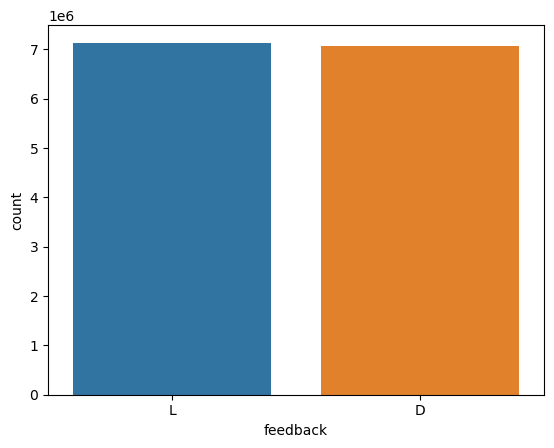

In [22]:
sns.countplot(x=interactions_df["feedback"])

In [23]:
interactions_df["feedback"] = interactions_df["feedback"].map({"L": 1, "D": -1})

### Encode ids to range of ids

In [11]:
ALL_TRAIN_USERS = list(set(interactions_df.userId))
ALL_TRAIN_TOPCIS = list(set(interactions_df.topicId))

USERID_TO_NORM = {}
ITEMID_TO_NORM = {}
for i, usr in enumerate(ALL_TRAIN_USERS):
    USERID_TO_NORM[usr] = i

for i, topic in enumerate(ALL_TRAIN_TOPCIS):
    ITEMID_TO_NORM[topic] = i

In [12]:
interactions_df['userId_index'] = interactions_df['userId'].map(lambda x: USERID_TO_NORM[x])
interactions_df['topicId_index'] = interactions_df['topicId'].map(lambda x: ITEMID_TO_NORM[x])

In [13]:
interactions_df

,topicId,userId,feedback,userId_index,topicId_index
0,198,1044368,1,1044351,198
1,154,1044368,1,1044351,154
2,6,1044368,-1,1044351,6
3,77,1044368,-1,1044351,77
4,81411,2604826,1,2585164,81411
...,...,...,...,...,...
14193799,231,703677,-1,703677,231
14193800,277,1095615,1,1095595,277
14193801,68,1095615,-1,1095595,68
14193802,14621,1095615,1,1095595,14621


### Encode unix birth date to age of the person

In [24]:
users_df["birthDate"] = users_df["birthDate"].map(lambda x: 2023 - pd.Timestamp(x // 1000).year)
users_df

,userId,birthDate,gender,locationId
0,2019458,53.0,2,5697551
1,96675,54.0,2,12141127
2,1378979,53.0,1,12141421
3,540187,53.0,1,4126402
4,1182831,53.0,2,2955426
...,...,...,...,...
2682252,1362388,54.0,1,4155306
2682253,470190,53.0,2,2117251
2682254,608546,53.0,2,2784685
2682255,1559056,54.0,2,2267414


## Make a CRF matrix from interactions_df

In [15]:
data = interactions_df["feedback"]
row = interactions_df["userId_index"]
col = interactions_df["topicId_index"]

user_post_interaction_csr = coo_matrix((data, (row, col))).tocsr()
user_post_interaction_csr

<2654885x202075 sparse matrix of type '<class 'numpy.int64'>'
	with 14193804 stored elements in Compressed Sparse Row format>

## Train a LightFM model

In [16]:
model = LightFM(no_components=100)

model = model.fit(user_post_interaction_csr,
                  epochs=25,
                  num_threads=16, verbose=True)

Epoch: 100%|██████████| 25/25 [09:50<00:00, 23.63s/it]


## Generate user and post embeddings

In [26]:
user_emb = pd.DataFrame(model.get_user_representations()[1])
user_emb["userId"] = ALL_TRAIN_USERS

topic_emb = pd.DataFrame(model.get_item_representations()[1])
renamers = {x: "topic" + str(x) for x in topic_emb.columns}
topic_emb.rename(columns=renamers, inplace=True)
topic_emb["topicId"] = ALL_TRAIN_TOPCIS

### Load posts' text and image embeddings

In [27]:
topics_df = pd.read_csv("../input/data-bdimo/topics.csv")

### Prepare val data

In [29]:
training_df, val_df = interactions_df.loc[:len(interactions_df) * 0.8], interactions_df.loc[len(interactions_df) * 0.8:]

## Train CatBoost model
Because the data is too large, I used partial_fit

In [30]:
N_BATCHES = 400
COLUMNS = []
N_SAMPLES_FOR_BATCH = len(training_df) // N_BATCHES

In [ ]:
val_df_merged = pd.merge(val_df, topics_df, how="left", on="topicId")
val_df_merged = pd.merge(val_df_merged, users_df, how="left", on="userId")
val_df_merged = pd.merge(val_df_merged, user_emb, how="left", on="userId") # topic_emb
val_df_merged = pd.merge(val_df_merged, topic_emb, how="left", on="topicId")

val_df_merged['gender'] = val_df_merged['gender'].astype('str')
val_df_merged['locationId'] = val_df_merged['locationId'].astype('str')
val_df_merged['userId'] = val_df_merged['userId'].astype('str')
val_df_merged['topicId'] = val_df_merged['topicId'].astype('str')

val_df_merged = val_df_merged.drop(columns=["userId", "topicId"])
X_val, y_val = val_df_merged.drop(columns=["feedback"]), val_df_merged["feedback"]
val_df_merged

In [ ]:
cat_model = CatBoostClassifier(learning_rate=0.2, iterations=4, eval_metric="TotalF1", use_best_model=True)

for batch_start in tqdm(range(0, len(training_df), N_SAMPLES_FOR_BATCH)):
    batch_main_df = training_df.iloc[batch_start:batch_start + N_SAMPLES_FOR_BATCH]

    batch_main_df_merged = pd.merge(batch_main_df, topics_df, how="left", on="topicId")
    batch_main_df_merged = pd.merge(batch_main_df_merged, users_df, how="left", on="userId")
    batch_main_df_merged = pd.merge(batch_main_df_merged, user_emb, how="left", on="userId")
    batch_main_df_merged = pd.merge(batch_main_df_merged, topic_emb, how="left", on="topicId")

    batch_main_df_merged['gender'] = batch_main_df_merged['gender'].astype('str')
    batch_main_df_merged['locationId'] = batch_main_df_merged['locationId'].astype('str')
    batch_main_df_merged['userId'] = batch_main_df_merged['userId'].astype('str')
    batch_main_df_merged['topicId'] = batch_main_df_merged['topicId'].astype('str')
    
    batch_main_df_merged = batch_main_df_merged.drop(columns=["userId", "topicId"])
    COLUMNS = batch_main_df_merged.columns
    X_train, y_train = batch_main_df_merged.drop(columns=["feedback"]), batch_main_df_merged["feedback"]
    
    if batch_start == 0:
        cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False, use_best_model=True, 
                      cat_features=['gender', 'locationId', 'userId', 'topicId']) 
    else:
        cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False, init_model="jopa_model.cbm", use_best_model=True,
                      cat_features=['gender', 'locationId', 'userId', 'topicId'])
    cat_model.save_model("jopa_model.cbm")

    print(accuracy_score(cat_model.predict(X_val), y_val))

Text(0.5, 1.0, 'Feature Importance')

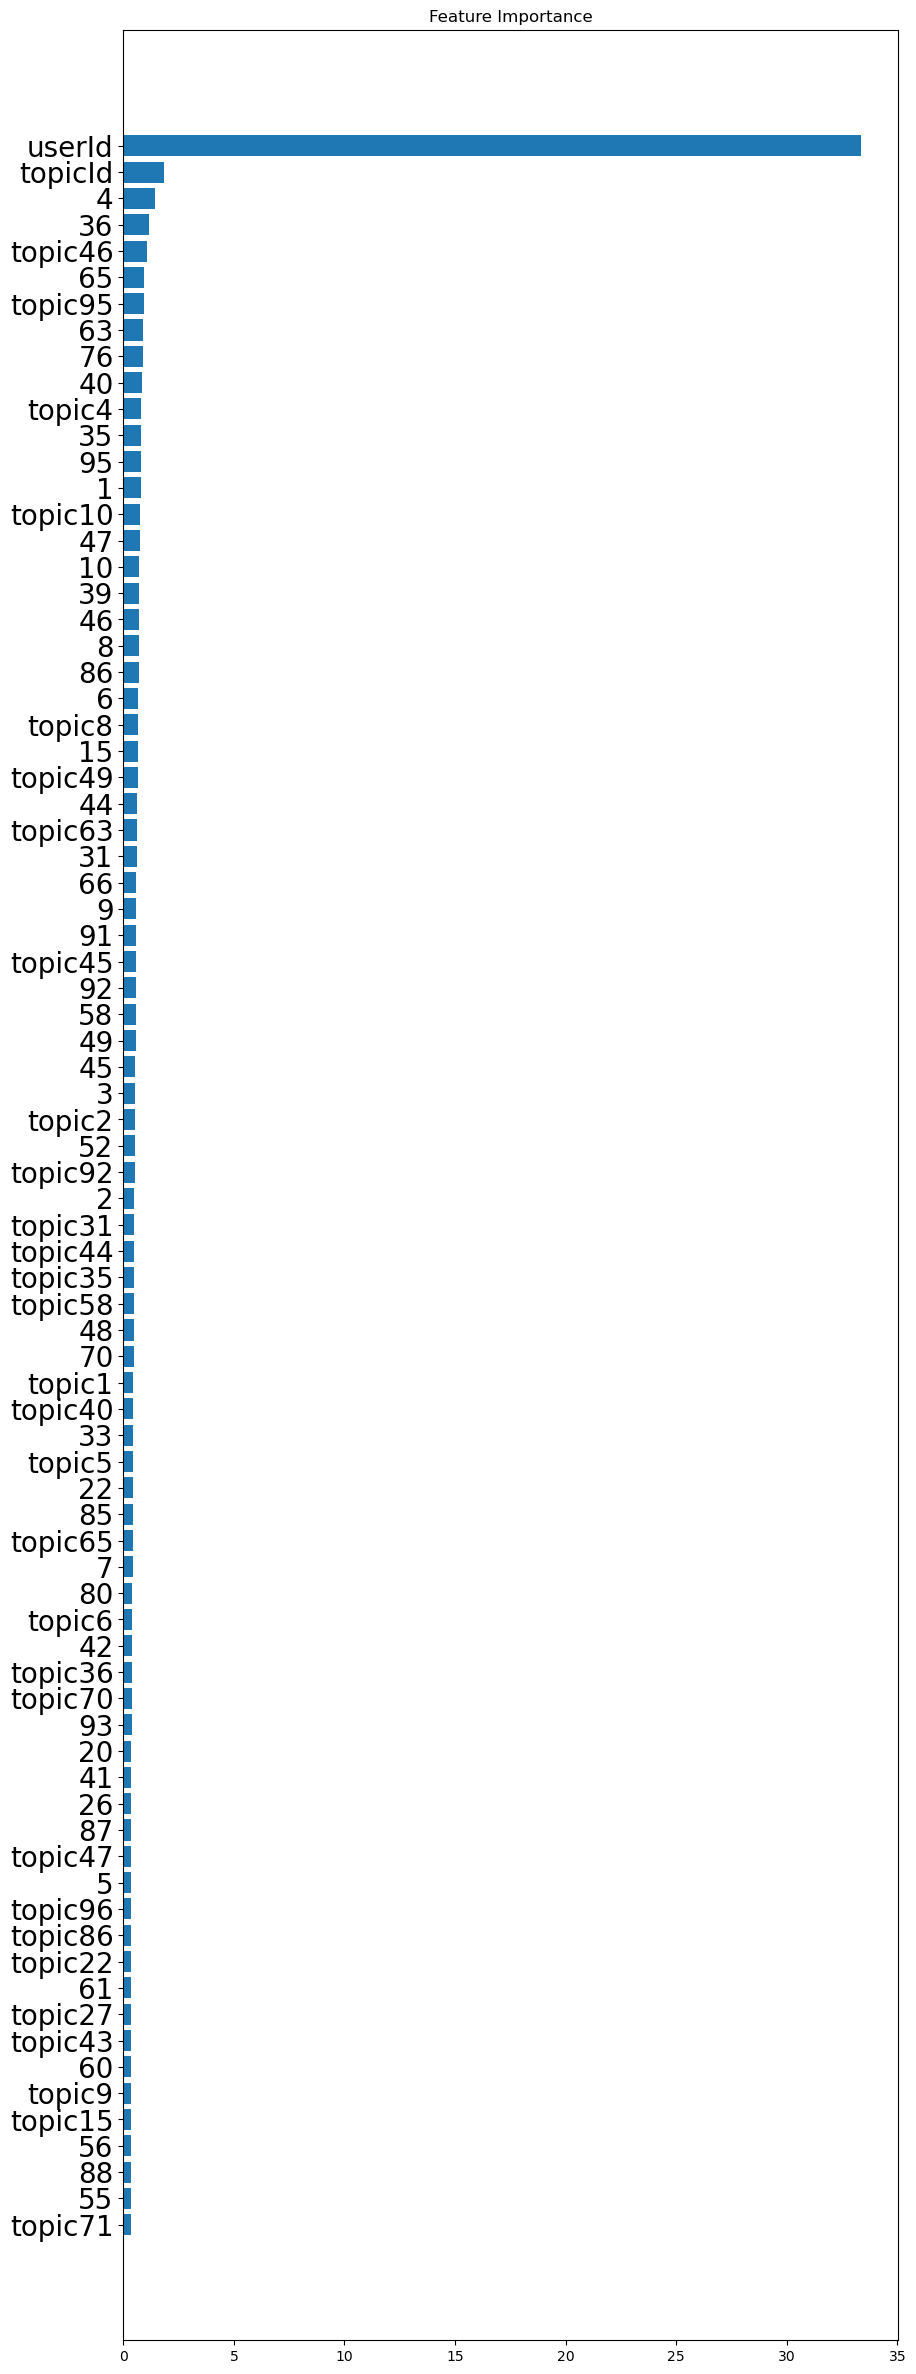

In [29]:
feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-80:]
fig = plt.figure(figsize=(10, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), COLUMNS[sorted_idx], size=20)
plt.title('Feature Importance')

# Prepare the submission file 

In [30]:
test_user_emb_df = pd.read_csv("../input/user-post/test.csv").copy()

In [35]:
N_BATCHES = 50
COLUMNS = []
N_SAMPLES_FOR_BATCH = len(test_user_emb_df) // N_BATCHES

In [36]:
PREDS = []
batch_main_df_merged = None
for batch_start in tqdm(range(0, len(test_user_emb_df), N_SAMPLES_FOR_BATCH)):
    batch_main_df = test_user_emb_df.iloc[batch_start:min(len(test_user_emb_df), batch_start + N_SAMPLES_FOR_BATCH)]

    batch_main_df_merged = pd.merge(batch_main_df, topics_df_text, how="left", on="topicId")
    batch_main_df_merged = pd.merge(batch_main_df_merged, users_df, how="left", on="userId")
    batch_main_df_merged = pd.merge(batch_main_df_merged, user_emb, how="left", on="userId")
    batch_main_df_merged = pd.merge(batch_main_df_merged, topic_emb, how="left", on="topicId")

    batch_main_df_merged.fillna(0)

    batch_main_df_merged = batch_main_df_merged.drop(columns=["userId", "topicId"])
    PREDS.extend(cat_model.predict(batch_main_df_merged))

  0%|          | 0/51 [00:00<?, ?it/s]

In [37]:
len(PREDS)

1578802

In [41]:
with open("submission_100_whole_userid.txt", mode="w") as file:
    print(*list(map(lambda x: "L" if x == 1 else "D", PREDS)), sep="\n", file=file)